In [130]:
import os
import geopandas as gp
import pandas as pd
import numpy as np
import ee
import shapely

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from climata.usgs import DailyValueIO
from shapely.geometry import Point
from shapely.ops import cascaded_union

ee.Initialize()

In [131]:
# First, make a merged shapefile of hucs of different orders from 1802, 1803, 1804

In [132]:
huc_order = "8"
huc_str = "WBDHU{}.shp".format(huc_order)

huc4s = ["1802", "1803", "1804"]
hu4_dirs = [os.path.join("../nhd", x, "Shape") for x in os.listdir("../nhd") if "." not in x]

In [135]:
def find_hucs(dir, huc_str):
    shp_files = [os.path.join(dir,x) for x in os.listdir(dir) if huc_str in x if "xml" not in x]
    return shp_files

gdfs = []

for i in hu4_dirs:
    gdfs.append(gp.read_file(find_hucs(i, huc_str)[0]))

gdf = gp.GeoDataFrame(pd.concat(gdfs, ignore_index=True))


In [164]:
# Read central valley shapefile
cv = gp.read_file("../shape/cv.shp")

# Read stream reaches from c2vsim shapefile 
reaches = gp.read_file("../c2vsim/C2VSimFG_StreamReaches.shp").dropna()

# Sierra side (eastern) huc8s from south to north: 

'''
sierra_hu8s = ["18030003", "18030004", "18030005", "18030006", "18030007", # 1803 Tulare
               "18030012", "18030009", "18040001", "18040007", "18040008", 
               "18040010", "18040011", "18040012", "18040013", "18040014", # 1804 San Joaquin 
               "18040010", "18040011", "18040012", "18040013", "18040014",
               "18040009", 
               "18020111", "18020161", "18020126", "18020125", "18020159", # 1802 Sac
               "18020158", "18020157", "18020155", "18020154", "18020151",
               "18020153", "18020156"]
               
'''

'\nsierra_hu8s = ["18030003", "18030004", "18030005", "18030006", "18030007", # 1803 Tulare\n               "18030012", "18030009", "18040001", "18040007", "18040008", \n               "18040010", "18040011", "18040012", "18040013", "18040014", # 1804 San Joaquin \n               "18040010", "18040011", "18040012", "18040013", "18040014",\n               "18040009", \n               "18020111", "18020161", "18020126", "18020125", "18020159", # 1802 Sac\n               "18020158", "18020157", "18020155", "18020154", "18020151",\n               "18020153", "18020156"]\n               \n'

In [170]:
reaches = reaches.to_crs({'init': 'epsg:4326'})

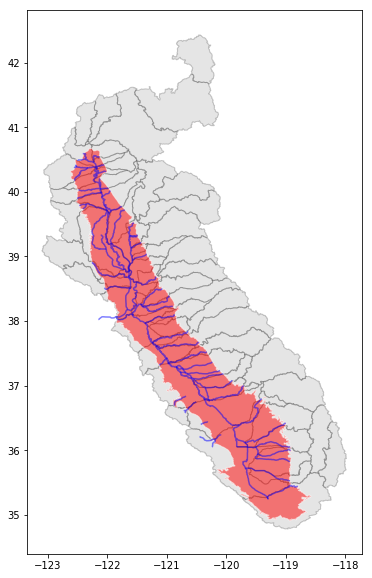

In [172]:
fig, ax = plt.subplots(figsize = (6, 10))
gdf.plot(ax = ax, color = "gray", alpha = 0.2, edgecolor='black')
cv.plot(ax = ax, color = "red", edgecolor = "white", alpha = 0.5)
reaches.plot(ax = ax, color = "blue", edgecolor = "blue", alpha = 0.5)

In [17]:
def get_streamflow(huc8):
    
    '''
    call climata API supplying huc8 argument to get each gaging station within each basin 
    '''
    
    data =  DailyValueIO (
            start_date="2001-01-01", 
            end_date="2018-01-01",
            basin=huc8,
            parameter="00060",
            )
    
    qs = []
    ds = []
    lats = []
    lons = []
    ids = []

    for series in data:
        values = []
        dates = []
        lats.append(series.latitude)
        lons.append(series.longitude)
        ids.append(series.site_code)

        for row in series.data:
            values.append(row.value)
            dates.append(row.date)

        qs.append(values)
        ds.append(dates)
    
    geometry = [Point(xy) for xy in zip(lons, lats)]
    df = pd.DataFrame(geometry)
    crs = {'init': 'epsg:4326'}
    gdf = gp.GeoDataFrame(df, crs=crs, geometry=geometry)
    
    return gdf, qs, ds, ids

In [18]:
gdfs = []
qs = []
ds = []
ids = []

for i in rdf['HUC8']:
    print (i)
    gdf, q, d, i = get_streamflow(i)
    gdfs.append(gdf)
    qs.append(q)
    ds.append(d)
    ids.append(i)


18020104
18020111
18020115
18020116
18020125
18020126
18020128
18020129
18020151
18020152
18020153
18020154
18020155
18020156
18020159
18020161
18020162
18020163
18020002
18020003
18020004
18020005
18020121
18020122
18020123
18020157
18020158
18020001
18040001
18040002
18040003
18040006
18040007
18040008
18040009
18040010
18040011
18040012
18040013
18040014
18040051
18030001
18030002
18030003
18030004
18030005
18030006
18030007
18030009
18030010
18030012


In [33]:
# Un-nest the lists

q_f = np.array([item for sublist in qs for item in sublist])
d_f = np.array([item for sublist in ds for item in sublist])
ids_f = [item for sublist in ids for item in sublist]

In [36]:
# Make a gdf of the stations and join the lists of q, ID and dates

stations_gdf = gp.GeoDataFrame(pd.concat(gdfs, ignore_index=True, sort = False))
stations_gdf['Q'] = q_f
stations_gdf['ID'] = ids_f
stations_gdf['dates'] = d_f

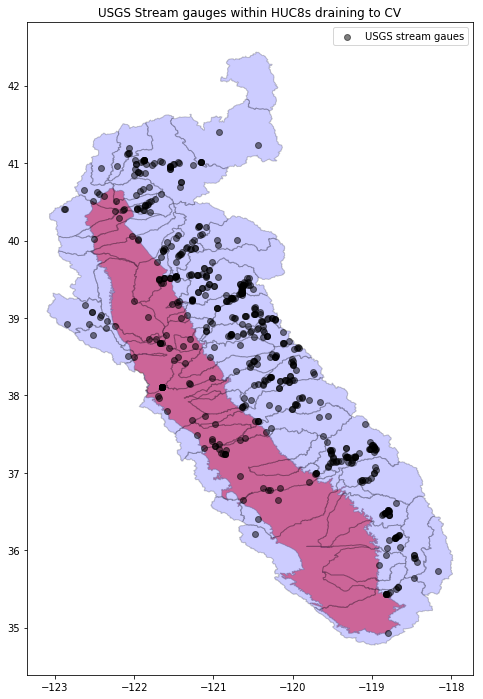

In [174]:
# Plot the stations

fig, ax = plt.subplots(figsize = (8, 12))
plt.title("USGS Stream gauges within HUC8s draining to CV")
cv.plot(ax = ax, color = "red",alpha = 0.5, edgecolor = "gray")
rdf.plot(ax = ax, color = "blue", alpha = 0.2, edgecolor='black')
stations_gdf.plot(ax=ax, marker="o", alpha=0.5, color = "black", label = "USGS stream gaues")

plt.legend()
plt.show()

In [61]:
# Compute the daily mean discharges and join to gdf

means = []
for i, x in enumerate(q_f): 
    means.append(np.mean(x))
    
stations_gdf['mean'] = means

# Extract some statistics for plotting
max_val = stations_gdf['mean'].max()
med_val = stations_gdf['mean'].median()
min_val = stations_gdf['mean'].min()

# Get stations corresponding to those vals
s1 = stations_gdf[stations_gdf['mean'] == max_val]
s2 = stations_gdf[stations_gdf['mean'] == med_val]
s3 = stations_gdf[stations_gdf['mean'] == min_val]

# Calc a few percentiles in the data 
p1 = np.percentile(stations_gdf['mean'],50)
p2 = np.percentile(stations_gdf['mean'],75)
p3 = np.percentile(stations_gdf['mean'],90)
p4 = np.percentile(stations_gdf['mean'],99)

/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


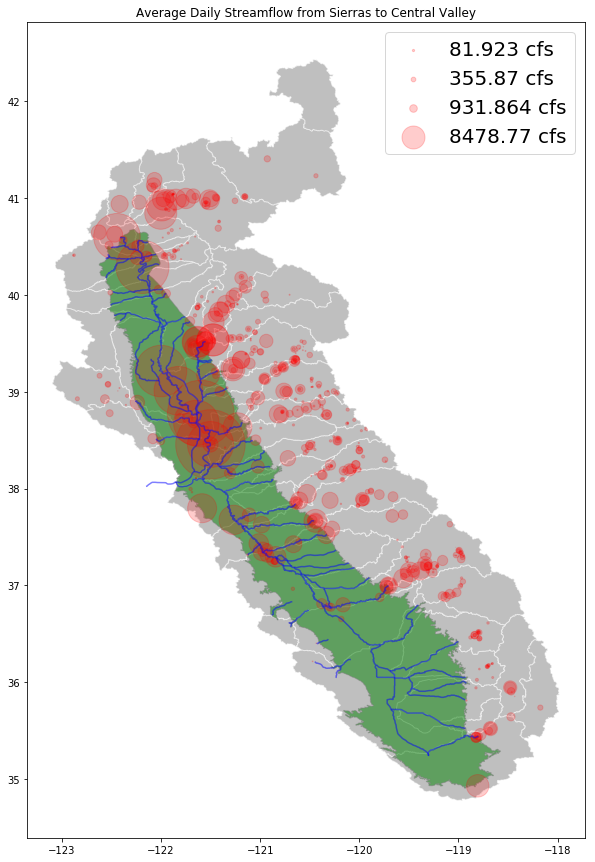

In [175]:
# Plot

fig, ax = plt.subplots(1, figsize=(10,15))
plt.title("Average Daily Streamflow from Sierras to Central Valley")

# Plot the dfs 
rdf.plot(ax = ax, color = "gray", alpha = 0.5, edgecolor = "white")
cv.plot(ax = ax, color = "green",alpha = 0.5, edgecolor = "gray")
stations_gdf.plot(ax=ax, marker=".", alpha=0.2, c = "red", markersize = stations_gdf['mean'])
reaches.plot(ax = ax, color = "blue", edgecolor = "blue", alpha = 0.5)

# Dummy objects for legend 
s3.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p1, label = "{} cfs".format(round(p1,3)))
s1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p2, label = "{} cfs".format(round(p2,3)))
s1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p3, label = "{} cfs".format(round(p3,3)))
s1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p4, label = "{} cfs".format(round(p4,3)))

plt.legend(markerscale = 0.5, prop={'size': 20})

plt.show()

In [81]:
# get 6 largest discharges and plot em
colors = ['red', 'blue', 'green', 'purple', 'yellow', 'orange']

largest = stations_gdf.nlargest(6, 'mean')
largest['color'] = colors

In [108]:
lgdfs = []

for i in range(0,6):
    lgdfs.append(gp.GeoDataFrame(largest.iloc[i]).T)


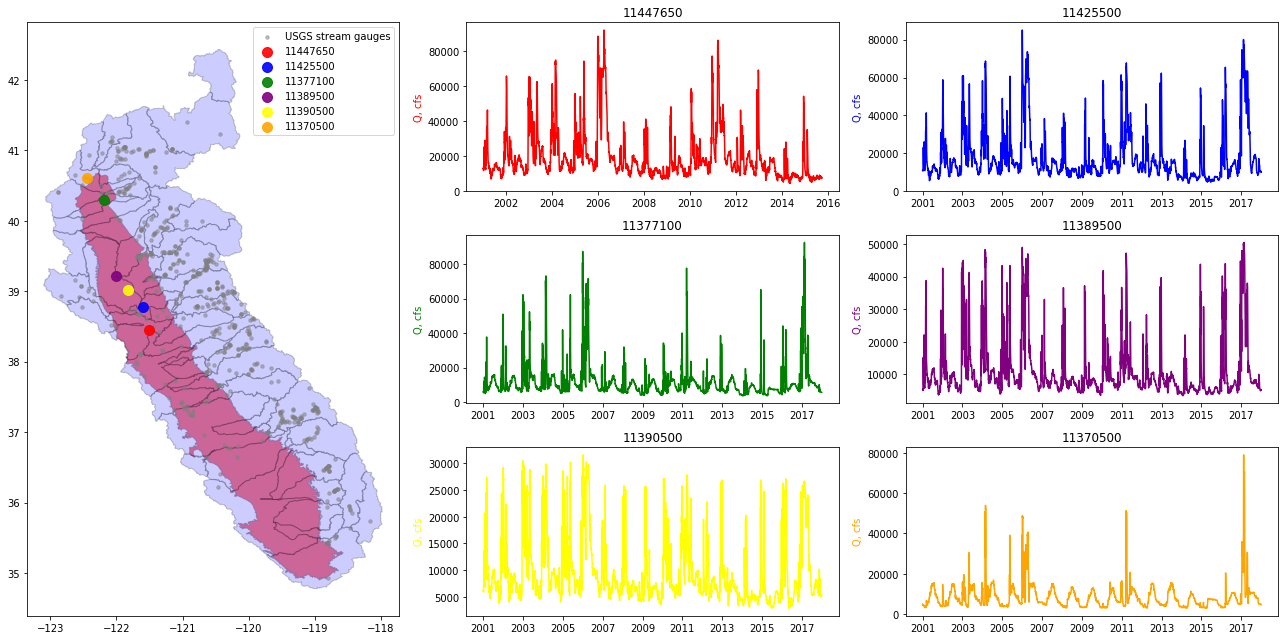

In [129]:
# Setup figure
plt.figure(figsize=(18, 9))
G = gridspec.GridSpec(3, 3)

# Plot the basemaps
axes_1 = plt.subplot(G[:, 0])
cv.plot(ax = axes_1, color = "red",alpha = 0.5, edgecolor = "gray")
rdf.plot(ax = axes_1, color = "blue", alpha = 0.2, edgecolor='black')
stations_gdf.plot(ax=axes_1, marker="o", alpha=0.5,markersize = 12, color = "gray", label = "USGS stream gauges")

# Plot nlargest stations
for i in range(0,6):
    lgdfs[i].plot(ax = axes_1, marker = "o", alpha = 0.9, color = largest.iloc[i].color, markersize =100, label = "{}".format(largest.iloc[i].ID))

axes_1.legend()

# Plot discharges on other timeseries

axes_2 = plt.subplot(G[0, 1])
axes_2.set_title(largest.iloc[0].ID)
axes_2.plot(largest.iloc[0].dates, largest.iloc[0].Q, color = largest.iloc[0].color)
axes_2.set_ylabel("Q, cfs",  color = largest.iloc[0].color )

axes_3 = plt.subplot(G[0, 2])
axes_3.set_title(largest.iloc[1].ID)
axes_3.plot(largest.iloc[1].dates, largest.iloc[1].Q, color = largest.iloc[1].color)
axes_3.set_ylabel("Q, cfs",  color = largest.iloc[1].color )

axes_4 = plt.subplot(G[1, 1])
axes_4.set_title(largest.iloc[2].ID)
axes_4.plot(largest.iloc[2].dates, largest.iloc[2].Q, color = largest.iloc[2].color)
axes_4.set_ylabel("Q, cfs",  color = largest.iloc[2].color )

axes_5 = plt.subplot(G[1, 2])
axes_5.set_title(largest.iloc[3].ID)
axes_5.plot(largest.iloc[3].dates, largest.iloc[3].Q, color = largest.iloc[3].color)
axes_5.set_ylabel("Q, cfs",  color = largest.iloc[3].color )

axes_6 = plt.subplot(G[2, 1])
axes_6.set_title(largest.iloc[4].ID)
axes_6.plot(largest.iloc[4].dates, largest.iloc[4].Q, color = largest.iloc[4].color)
axes_6.set_ylabel("Q, cfs",  color = largest.iloc[4].color )

axes_7 = plt.subplot(G[2, 2])
axes_7.set_title(largest.iloc[5].ID)
axes_7.plot(largest.iloc[5].dates, largest.iloc[5].Q, color = largest.iloc[5].color)
axes_7.set_ylabel("Q, cfs",  color = largest.iloc[5].color )

plt.tight_layout()
plt.show()

In [197]:
usgs_stations = stations_gdf.drop([0, "Q", "dates"], axis = 1)
# usgs_stations.to_file("../Shape/usgs_q_stations.shp")

In [29]:
# Extract mean discharges from timeseries

In [304]:
s = gp.read_file("../Shape/1802_4.shp")
sj = gp.read_file("../Shape/1804_4.shp")
t = gp.read_file("../Shape/1803_4.shp")
basins = gp.read_file("../Shape/ca_gw_basins.shp")

/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/matplotlib/collections.py:902: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


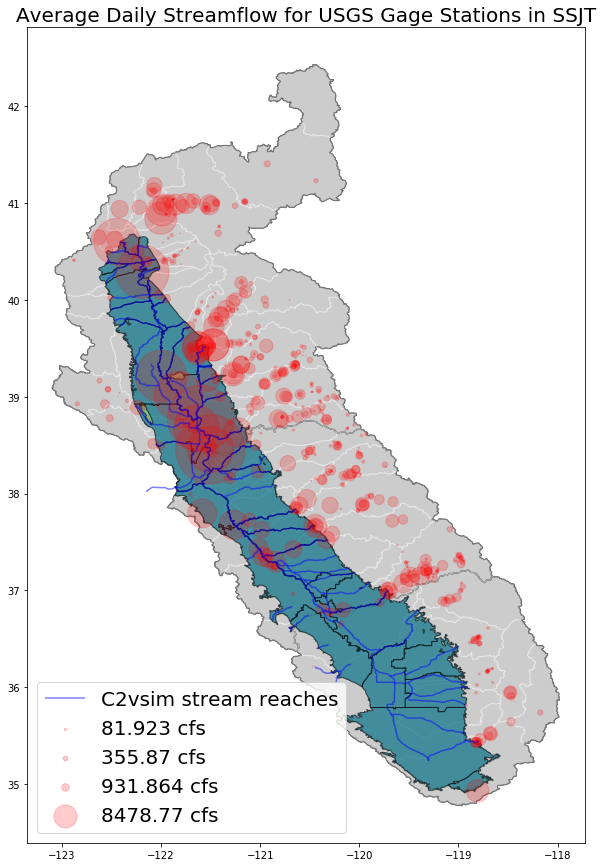

In [305]:
fig, ax = plt.subplots(1, figsize=(10,15))

plt.title("Average Daily Streamflow for USGS Gage Stations in SSJT", size = 20)

# Plot the huc4s
s.plot(ax = ax, color = 'none', edgecolor = "black")
sj.plot(ax = ax, color = 'none', edgecolor = "black")
t.plot(ax = ax, color = 'none',   edgecolor = "black")

# Plot the dfs 
gdf.plot(ax = ax, color = "gray", alpha = 0.4, edgecolor = "white")
cv.plot(ax = ax, color = "green",alpha = 0.4, edgecolor = "gray")
basins.plot(ax = ax, alpha = 0.6, edgecolor = "black")
stations_gdf.plot(ax=ax, marker=".", alpha=0.2, c = "red", markersize = stations_gdf['mean'])
reaches.plot(ax = ax, color = "blue", edgecolor = "blue", alpha = 0.5, label = "C2vsim stream reaches")

# Dummy objects for legend 
s3.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p1, label = "{} cfs".format(round(p1,3)))
s1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p2, label = "{} cfs".format(round(p2,3)))
s1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p3, label = "{} cfs".format(round(p3,3)))
s1.plot(ax = ax, marker = ".", alpha=0.2, c = "red", markersize = p4, label = "{} cfs".format(round(p4,3)))


plt.legend(markerscale = 0.5, prop={'size': 20})

# plt.savefig("../figs/ssjt_Qs.png")

plt.show()

In [306]:
# Get data for stations draining into CV (according to Xiao): 
# https://agupubs.onlinelibrary.wiley.com/action/downloadSupplement?doi=10.1002%2F2017GL073333&file=grl55820-sup-0001-Supplementary.pdf

In [307]:
# Stations from Xiao:
stations = [11446500, 11376550, 11423800, 11384000, 11390000 ,11451760,
            11372000, 11335000, 11376000, 11374000, 11383500, 11329500,
            11211300, 11424500, 11379500, 11407150, 11257500, 11209900,
            11192950, 11251600, 11225000, 11270900, 11381500, 11221700,
            11325500, 11384350, 11454000, 11370500, 11251000, 11302000,
            11388000, 11382000, 11289650, 11199500, 11421000]

# Stations I added in last row 
stations = [11446500, 11376550, 11423800, 11384000, 11390000 ,11451760,
            11372000, 11335000, 11376000, 11374000, 11383500, 11329500,
            11211300, 11424500, 11379500, 11407150, 11257500, 11209900,
            11192950, 11251600, 11225000, 11270900, 11381500, 11221700,
            11325500, 11384350, 11454000, 11370500, 11251000, 11302000, 
            11388000, 11382000, 11289650, 11199500, 11421000, 
           
            11208818, 11204100, 11200800, 11218400, 11289000, 11323500
           ]

# The CA Aqueduct takes water out of the CV: 
stations_out = ["11109396"]

stations = [str(x) for x in stations]

In [308]:
inflow = stations_gdf[stations_gdf['ID'].isin(stations)]
outflow = stations_gdf[stations_gdf.ID == "11109396"]

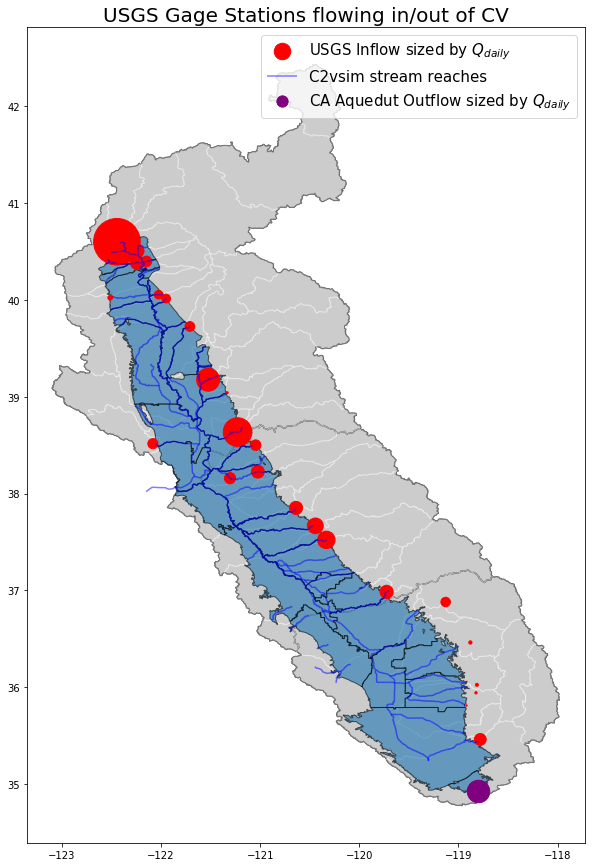

In [311]:
fig, ax = plt.subplots(1, figsize=(10,15))

plt.title("USGS Gage Stations flowing in/out of CV", size = 20)

# Plot the huc4s
s.plot(ax = ax, color = 'none', edgecolor = "black")
sj.plot(ax = ax, color = 'none', edgecolor = "black")
t.plot(ax = ax, color = 'none',   edgecolor = "black")

# Plot the dfs 
gdf.plot(ax = ax, color = "gray", alpha = 0.4, edgecolor = "white")
# cv.plot(ax = ax, color = "green",alpha = 0.4, edgecolor = "gray")
basins.plot(ax = ax, alpha = 0.6, edgecolor = "black")
inflow.plot(ax=ax, marker=".", alpha=1, c = "red", markersize = inflow['mean'], label = "USGS Inflow sized by $Q_{daily}$ ")
reaches.plot(ax = ax, color = "blue", edgecolor = "blue", alpha = 0.5, label = "C2vsim stream reaches")
outflow.plot(ax=ax, marker=".", alpha=1, c = "purple", markersize = outflow['mean'], label = "CA Aquedut Outflow sized by $Q_{daily}$ ")

plt.legend(markerscale = 0.5, prop={'size': 15})

# plt.savefig("../figs/ssjt_Qs.png")

plt.show()

In [326]:
q_arrs = []
d_arrs = []

for i in range(len(inflow)):
    q_arrs.append(inflow.iloc[i].Q)
    d_arrs.append(inflow.iloc[i].dates)


In [335]:
dfs = []

for i,x in enumerate(q_arrs):
    df = pd.DataFrame({'q':q_arrs[i],'date':d_arrs[i]})
    df = df.set_index(pd.DatetimeIndex(df['date']))
    df.drop(['date'], axis = 1, inplace = True)
    monthly =  df.resample('M').sum()
    dfs.append(monthly)

In [338]:
# If there are more outflows, need to make this a loop 

q_out = outflow.iloc[0].Q
q_out_d = outflow.iloc[0].dates

df_o = pd.DataFrame({'q_out':q_out,'date':q_out_d})
df_o = df_o.set_index(pd.DatetimeIndex(df_o['date']))
df_o.drop(['date'], axis = 1, inplace = True)
monthly_out =  df.resample('M').sum() * -1

In [342]:
dfs.append(monthly_out)

t = pd.concat(dfs, axis=1)
sums = t.sum(axis=1, skipna=True)

In [344]:
sums = sums * 0.0283168 * 1e-9 * 86400

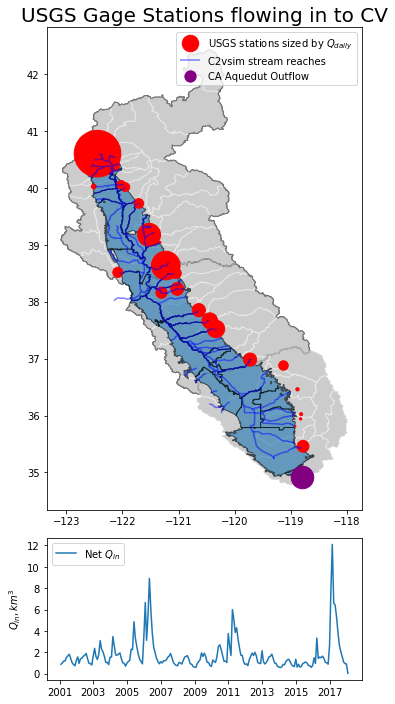

In [353]:
# Setup figure
plt.figure(figsize=(18, 12))
G = gridspec.GridSpec(4,6)

# Plot the basemaps
ax = plt.subplot(G[:3, :2])
plt.title("USGS Gage Stations flowing in to CV", size = 20)

# Plot the huc4s
s.plot(ax = ax, color = 'none', edgecolor = "black")
sj.plot(ax = ax, color = 'none', edgecolor = "black")

# Plot the dfs 
gdf.plot(ax = ax, color = "gray", alpha = 0.4, edgecolor = "white")
basins.plot(ax = ax, alpha = 0.6, edgecolor = "black")
inflow.plot(ax=ax, marker=".", alpha=1, c = "red", markersize = inflow['mean'], label = "USGS stations sized by $Q_{daily}$ ")
reaches.plot(ax = ax, color = "blue", edgecolor = "blue", alpha = 0.5, label = "C2vsim stream reaches")
outflow.plot(ax=ax, marker=".", alpha=1, c = "purple", markersize = outflow['mean'], label = "CA Aquedut Outflow")

plt.legend(markerscale = 0.5, prop={'size': 10})

# Timeseries
ax2 = plt.subplot(G[3:, 0:2])
ax2.set_ylabel("$Q_{in}, km^3$")
ax2.plot(sums, label ="Net $Q_{in}$" )
ax2.legend()

plt.show()

In [354]:
sums.to_csv("../data/Qs_in_monthly.csv")

In [ ]:
## NEXT TODO: 

'''
1) Calculate "Flashiest" gauges - use daily data
2) Join streamflow (means?) to HUCs 
3) Compare flashiest gauges and HUC8 means to soils maps / recharge areas? 
4) 

'''

In [300]:
outflow

,0,geometry,Q,ID,dates,mean
492,POINT (-118.8056509 34.9294166),POINT (-118.8056509 34.9294166),"[2840.0, 2200.0, 1950.0, 1950.0, 1950.0, 1950....",11109396,"[2001-01-01 00:00:00, 2001-01-02 00:00:00, 200...",2028.095338


In [56]:
ids_filt = [idx for idx,x in enumerate(ids_f) if x in stations]

In [65]:
vals_filt = [q_f[i] for i in ids_filt] 
dates_filt = [d_f[i] for i in ids_filt]

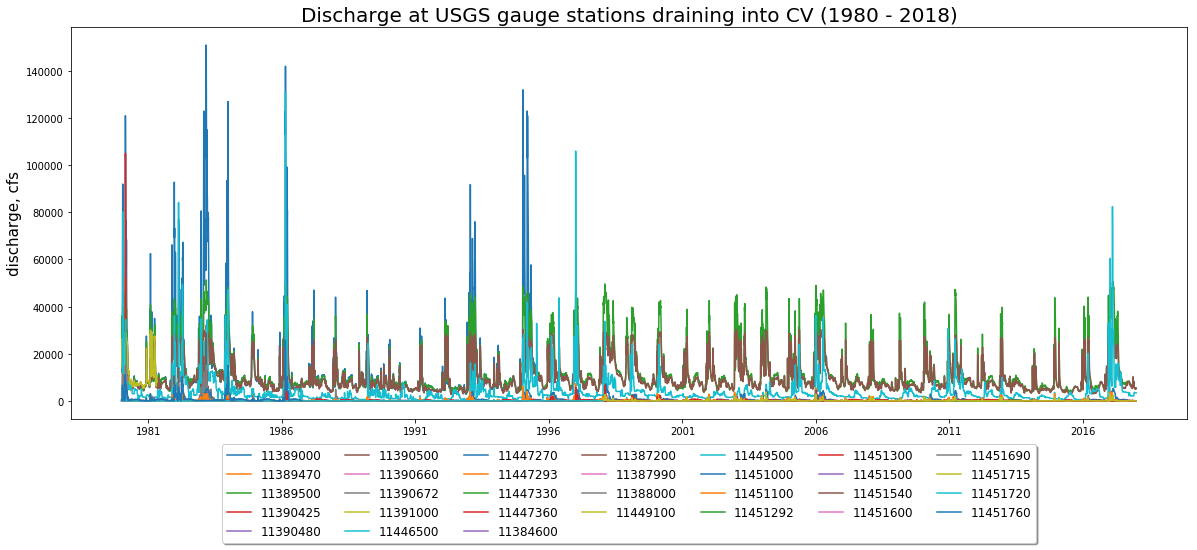

In [78]:
fig = plt.figure(figsize = (20,8))
ax = plt.subplot(111)

for i, x in enumerate(vals_filt):
    line = ax.plot(d_f[i],(q_f[i]), label = ids_f[i])
    
# ax.legend(loc='upper left',ncol=7, fancybox=True, prop={'size': 12})

box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=7, prop = {"size":12})

plt.xlabel("year", size = 15)
plt.ylabel("discharge, cfs", size = 15)
plt.title("Discharge at USGS gauge stations draining into CV (1980 - 2018)", size = 20)
plt.show()

In [189]:
# Make a df of everything

in_dfs = []

for idx, x in enumerate(q_f):
    sdf1 = pd.DataFrame(q_f[idx], d_f[idx], columns = [ids_f[idx]])
    in_dfs.append(sdf1)

In [190]:
fin = pd.concat(in_dfs, axis = 1)
fin.head()

,11389000,11389470,11389500,11390425,11390480,11390500,11390660,11390672,11391000,11446500,...,11216500,11217000,11218400,11218500,11218501,11218700,11197250,11221500,11221700,11224500
1980-01-01,34800.0,1690.0,25000.0,2830.0,3780.0,24000.0,145.0,7.4,24800.0,2540.0,...,8.6,117.0,275.0,1020.0,1070.0,93.0,0.19,58.0,35.0,0.57
1980-01-02,22900.0,40.0,36000.0,3050.0,3930.0,24200.0,69.0,4.1,26200.0,2570.0,...,8.0,73.0,160.0,710.0,883.0,192.0,0.19,72.0,21.0,0.51
1980-01-03,16800.0,0.0,19900.0,3010.0,202.0,21500.0,46.0,3.1,23100.0,3960.0,...,7.9,59.0,128.0,620.0,703.0,117.0,0.19,84.0,16.0,0.47
1980-01-04,15000.0,0.0,16100.0,2600.0,0.0,17700.0,32.0,2.6,18300.0,5340.0,...,7.7,49.0,110.0,560.0,632.0,108.0,0.19,86.0,14.0,0.41
1980-01-05,14200.0,0.0,14900.0,2050.0,0.0,16000.0,25.0,2.2,16500.0,5360.0,...,7.8,43.0,99.0,525.0,632.0,137.0,0.19,90.0,13.0,0.39


In [191]:
# Filter for the stations of interest

fin_in = fin.loc[:, fin.columns.str.contains('|'.join(stations))]

# calc the daily sums in
fin_in['sum_cfs'] = fin_in.sum(axis = 1)

# Calc the monthly sums
sum_df = pd.DataFrame(fin_in['sum_cfs'].resample('M', how='sum'))

# Convert cfs to km3 / mon
sum_df['sum_km3'] = sum_df.sum_cfs * 0.0283168 * 1e-9 * 86400

/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


Text(0,0.5,'$km^3$')

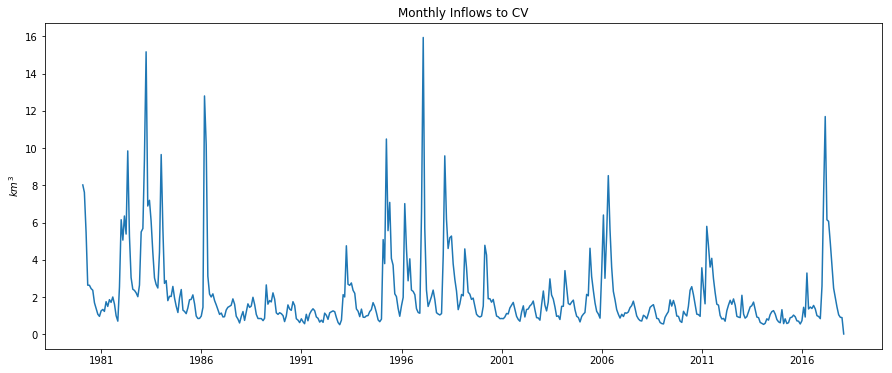

In [193]:
plt.figure(figsize=(15,6))
plt.title("Monthly Inflows to CV")
plt.plot(sum_df.sum_km3)
plt.ylabel("$km^3$")


In [194]:
sum_df.to_csv("../data/Q_s_into_CV.csv")